# Generate masks for each image 

In [1]:
import pathlib
import urllib.request

import cv2
import numpy as np

# from segment_anything import SamPredictor
import supervision as sv
import supervision.draw.color as sv_color
import torch
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from skimage import io
from tqdm import tqdm

In [2]:
model_type = "vit_h"

# set path to the model
path_to_model = "../../data/models/"

if model_type == "vit_h":
    CHECKPOINT_PATH = pathlib.Path("../../data/models/sam_vit_h_4b8939.pth")
    if not pathlib.Path("../../data/models/sam_vit_h_4b8939.pth").exists():
        url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
        # mkdir if not exists
        pathlib.Path(path_to_model).mkdir(parents=True, exist_ok=True)
        print("Downloading model...")
        !wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
        model_path = pathlib.Path("sam_vit_h_4b8939.pth").resolve(strict=True)
        # move the model
        CHECKPOINT_PATH.parent.mkdir(parents=True, exist_ok=True)
        model_path.rename(CHECKPOINT_PATH)
        print("Model downloaded")
    print("Model already exists")
elif model_type == "vit_l":
    CHECKPOINT_PATH = pathlib.Path("../../data/models/sam_vit_l_0b3195.pth")
    if not pathlib.Path("../../data/models/sam_vit_l_0b3195.pth").exists():
        # mkdir if not exists
        pathlib.Path(path_to_model).mkdir(parents=True, exist_ok=True)
        print("Downloading model...")
        !wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth'
        model_path = pathlib.Path("sam_vit_l_0b3195.pth").resolve(strict=True)
        # move the model
        CHECKPOINT_PATH.parent.mkdir(parents=True, exist_ok=True)
        model_path.rename(CHECKPOINT_PATH)
        print("Model downloaded")
    print("Model already exists")
elif model_type == "vit_b":
    CHECKPOINT_PATH = pathlib.Path("../../data/models/sam_vit_b_01ec64.pth")
    if not pathlib.Path("../../data/models/sam_vit_b_01ec64.pth").exists():
        # mkdir if not exists
        pathlib.Path(path_to_model).mkdir(parents=True, exist_ok=True)
        print("Downloading model...")
        !wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
        model_path = pathlib.Path("sam_vit_b_01ec64.pth").resolve()
        # move the model
        CHECKPOINT_PATH.parent.mkdir(parents=True, exist_ok=True)
        model_path.rename(CHECKPOINT_PATH)
        print("Model downloaded")
    print("Model already exists")
else:
    raise ValueError(f"Unknown model type: {model_type}")

Model already exists


## Define Paths

In [3]:
# max_projection paths
max_projection_path = pathlib.Path("../../data/3.maximum_projections_and_masks/")
# output mask path
mask_path = pathlib.Path("../../data/3.maximum_projections_and_masks")
# models path
models_path = pathlib.Path("../../data/models/")

# create directories if they don't exist
max_projection_path.mkdir(parents=True, exist_ok=True)
mask_path.mkdir(parents=True, exist_ok=True)
models_path.mkdir(parents=True, exist_ok=True)

In [4]:
# Generate a list of all the images in the image_path directory of max projection images
image_list = list(max_projection_path.glob("*.tiff"))
print(len(image_list))

83


## Load in the SAM model

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

sam = sam_model_registry[model_type](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam, points_per_side=1, points_per_batch=64, min_mask_region_area=500
)

cuda


In [6]:
def mask_image(
    image_path: str,
    gaussian_kernel: tuple = (5, 5),
    gaussian_std=5,
    alpha=75,
    beta=0,
) -> None:
    """
    This function takes in an image path and applies a gaussian blur, contrast adjustment, and thresholding to the image
    to create a binary mask image. The mask image is then saved to the mask_path directory with the same basename as the
    original tiff image.

    Args:
    image_path: str: path to the image

    gaussian_kernal: tuple: the size of the gaussian kernal to be used for the gaussian blur

    gaussian_std: int: the standard deviation to be used for the gaussian blur

    alpha: int: the contrast to be used for the contrast adjustment

    beta: int: the brightness to be used for the contrast adjustment

    Returns:
    None"""

    image_path = str(image_path)
    # read the image
    image = cv2.imread(image_path)
    # adjust the contrast of the image
    image = cv2.GaussianBlur(
        image, gaussian_kernel, gaussian_std
    )  # first tuple is the kernel size, second is the standard deviation
    image = cv2.convertScaleAbs(
        image, alpha=alpha, beta=beta
    )  # alpha is the contrast and beta is the brightness
    # define the file basename
    image_path = pathlib.Path(image_path)
    file_basename = image_path.stem
    # convert to unit8 format
    image = (image * 255).astype(np.uint8)
    # invert the image
    image = cv2.bitwise_not(image)
    # # segment the image
    masks = mask_generator.generate(image)

    # # annotate the masks
    mask_annotator = sv.MaskAnnotator(
        color=sv_color.Color(r=255, g=0, b=255), color_lookup=sv.ColorLookup.INDEX
    )
    # # detect the masks
    detections = sv.Detections.from_sam(sam_result=masks)

    # annotate the image
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

    # Convert to uint8 format for conversion to grayscale
    mask_image = (annotated_image * 255).astype(np.uint8)

    # convert image to grayscale
    gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    # threshold the image to create a binary mask image
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # invert the image such that the background is black and the signal are white
    gray = cv2.bitwise_not(gray)
    # write the image to mask with basename
    outpath = str(pathlib.Path(mask_path, file_basename + ".png"))
    cv2.imwrite(outpath, gray)
    io.imshow(outpath)

## Loop over the files and segment masks

100%|██████████| 83/83 [00:35<00:00,  2.33it/s]


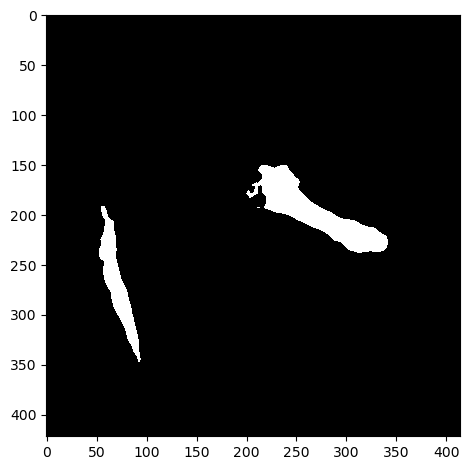

In [7]:
for image_path in tqdm(image_list):
    # set parms to match genotype
    if "wt" in image_path.stem:
        alpha = 15
        beta = 0
    elif "high" in image_path.stem:
        alpha = 25
        beta = 0
    elif "unsel" in image_path.stem:
        alpha = 25
        beta = 0
    else:
        alpha = 50
        beta = 0
    mask_image(
        image_path, gaussian_kernel=(5, 5), gaussian_std=5, alpha=alpha, beta=beta
    )

## individual mask generation for wrong masks  
While the above approach works well for most of the images, there are some images where the masks are not accurate.
For these images, we will use a different approach to generate the masks.
We will simply adjust the contrast of the image and apply the same model to generate the masks.

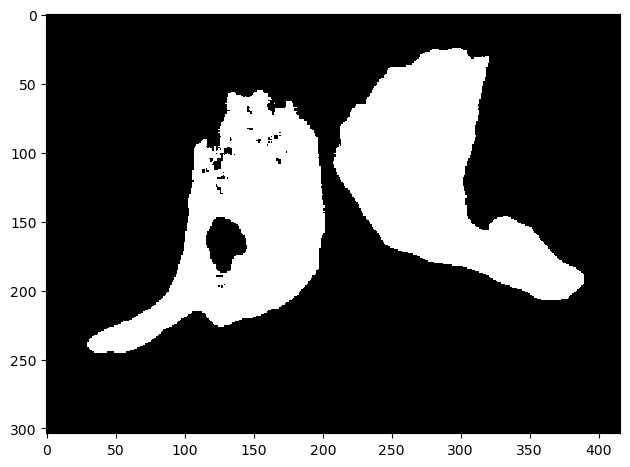

In [8]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_8_R.tiff", alpha=35, beta=0
)

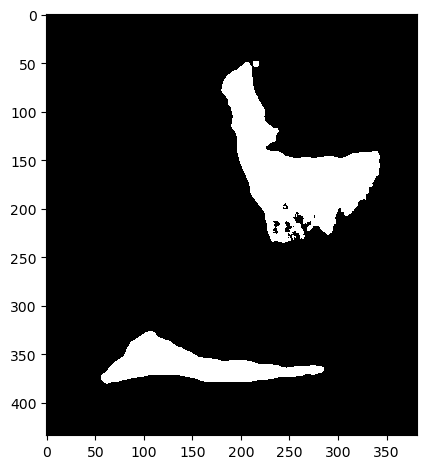

In [9]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_8_L.tiff", alpha=30, beta=0
)

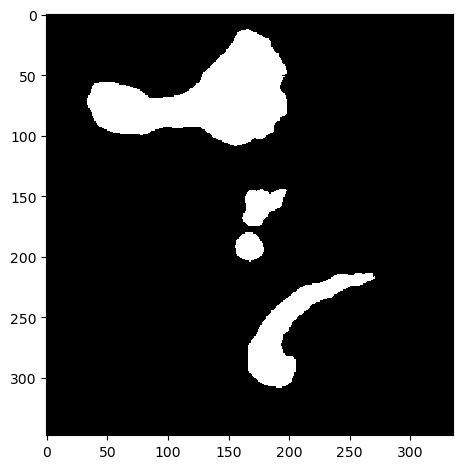

In [10]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_7_L.tiff", alpha=20, beta=0
)

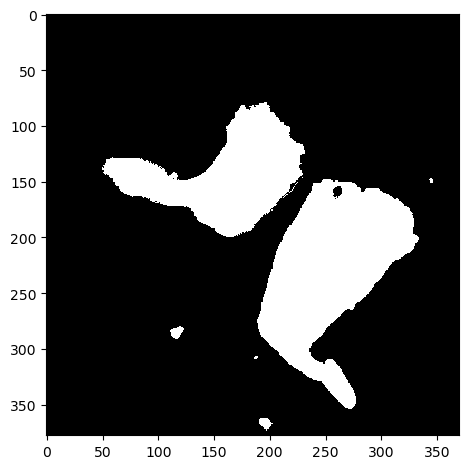

In [11]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_6_L.tiff", alpha=20, beta=0
)

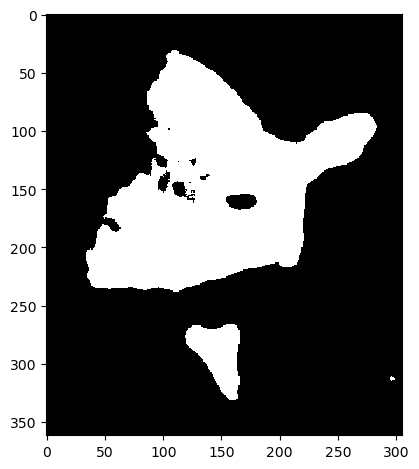

In [12]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_5_R.tiff", alpha=30, beta=0
)

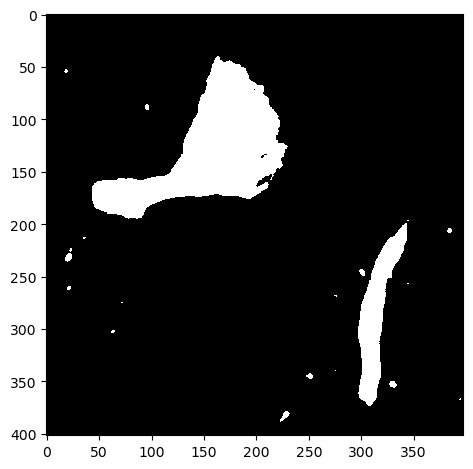

In [13]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_5_L.tiff", alpha=30, beta=0
)

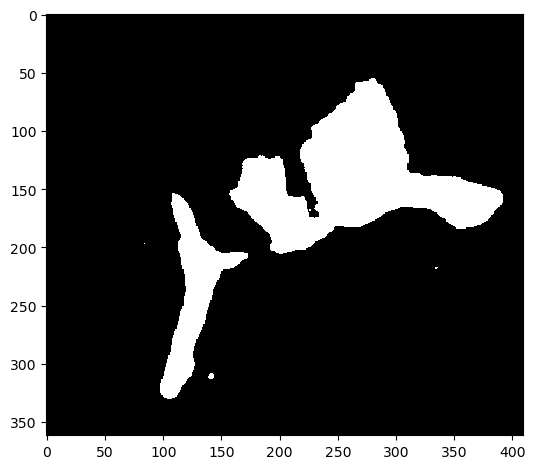

In [14]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_1_R.tiff", alpha=30, beta=0
)

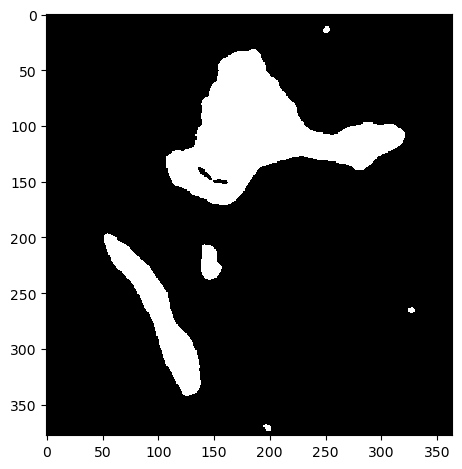

In [15]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_12_R.tiff", alpha=30, beta=0
)

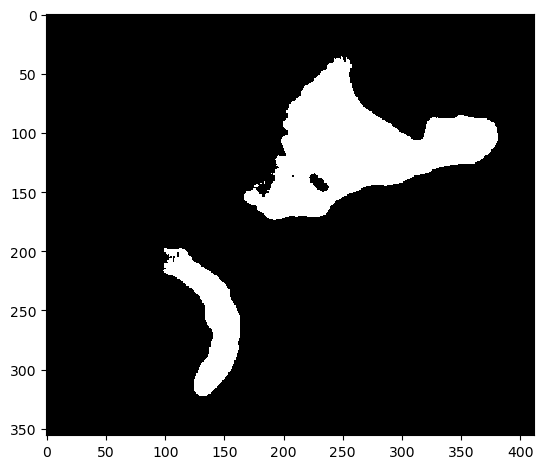

In [16]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_10_R.tiff", alpha=30, beta=0
)

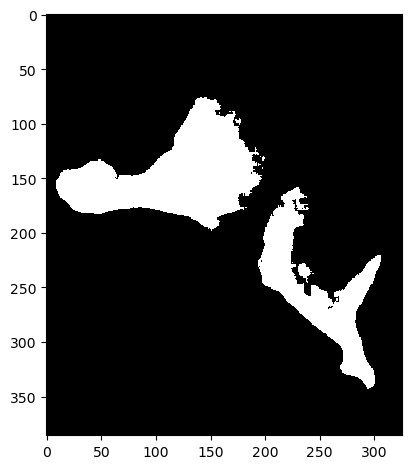

In [17]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_unsel_10_L.tiff", alpha=20, beta=0
)

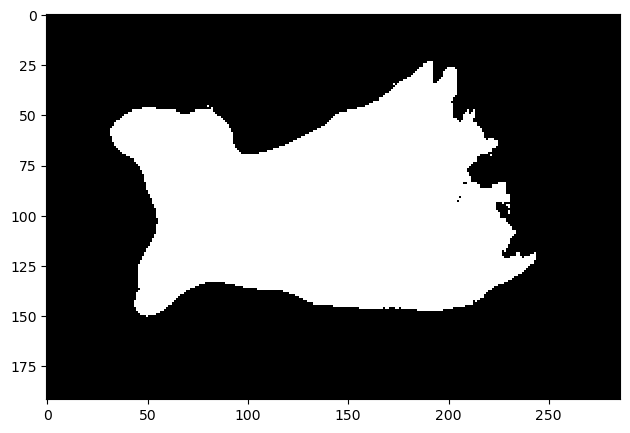

In [18]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_high_9_L.tiff", alpha=20, beta=0
)

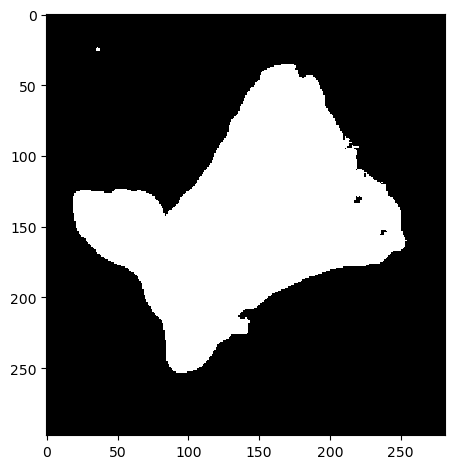

In [19]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_high_6_R.tiff", alpha=20, beta=0
)

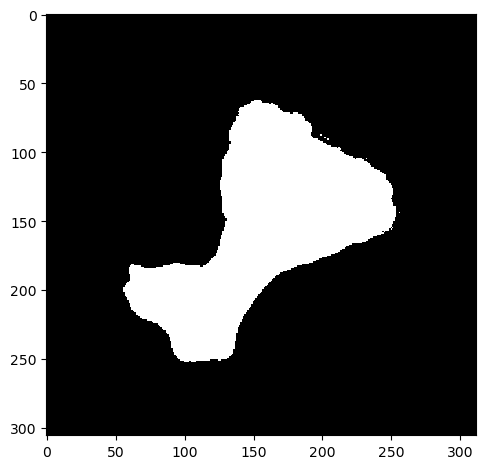

In [20]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_high_5_L.tiff", alpha=20, beta=0
)

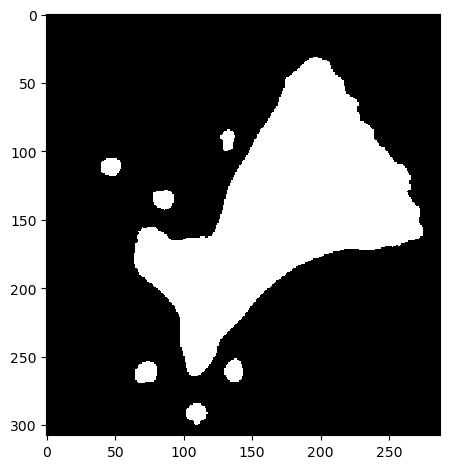

In [21]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_high_3_L.tiff", alpha=20, beta=0
)

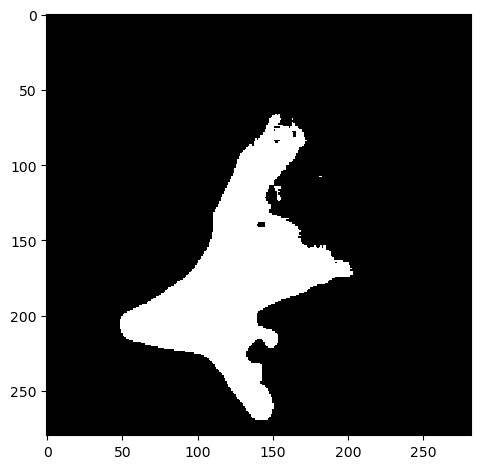

In [22]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_high_2_R.tiff", alpha=20, beta=0
)

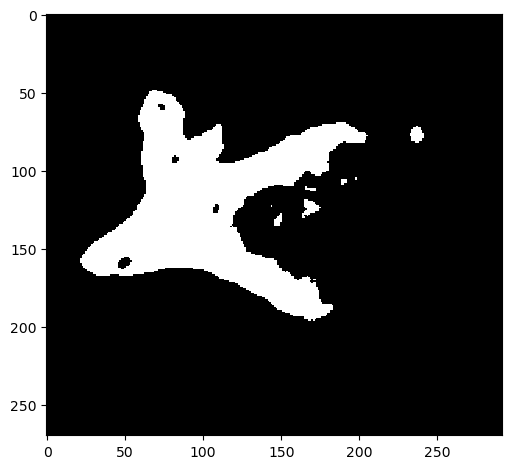

In [23]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_high_2_L.tiff", alpha=20, beta=0
)

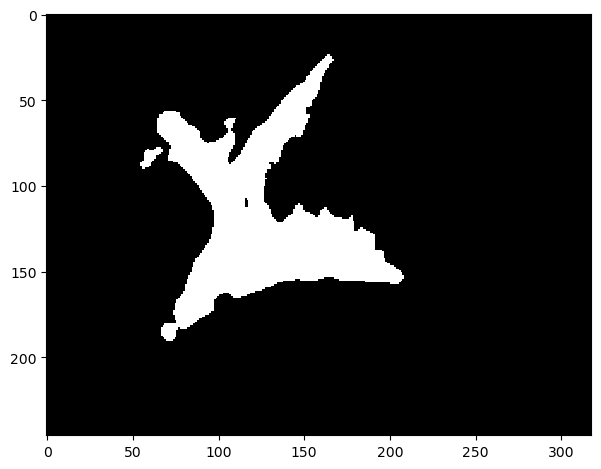

In [24]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_high_1_L.tiff", alpha=10, beta=0
)

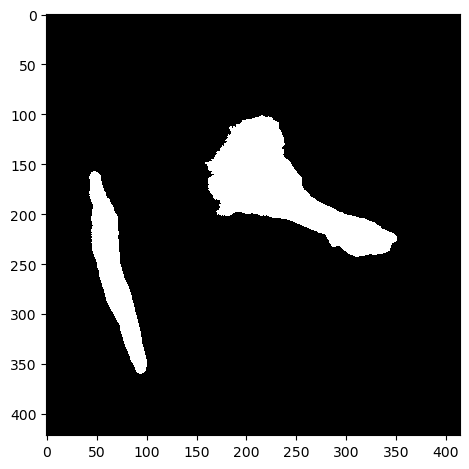

In [25]:
mask_image(
    "../../data/3.maximum_projections_and_masks/MAX_wt_9_R.tiff", alpha=60, beta=0
)